# 推荐系统

## 下载数据集
运行下面代码把[`数据集`](http://files.grouplens.org/datasets/movielens/ml-1m.zip)下载下来

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf

import os
import pickle
import re
from tensorflow.python.ops import math_ops

In [14]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import hashlib

def _unzip(save_path, _, database_name, data_path):
    """
    Unzip wrapper with the same interface as _ungzip
    :param save_path: The path of the gzip files
    :param database_name: Name of database
    :param data_path: Path to extract to
    :param _: HACK - Used to have to same interface as _ungzip
    """
    print('Extracting {}...'.format(database_name))
    with zipfile.ZipFile(save_path) as zf:
        zf.extractall(data_path)

def download_extract(database_name, data_path):
    """
    Download and extract database
    :param database_name: Database name
    """
    DATASET_ML1M = 'ml-1m'

    if database_name == DATASET_ML1M:
        url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
        hash_code = 'c4d9eecfca2ab87c1945afe126590906'
        extract_path = os.path.join(data_path, 'ml-1m')
        save_path = os.path.join(data_path, 'ml-1m.zip')
        extract_fn = _unzip

    if os.path.exists(extract_path):
        print('Found {} Data'.format(database_name))
        return

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(database_name)) as pbar:
            urlretrieve(
                url,
                save_path,
                pbar.hook)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        extract_fn(save_path, extract_path, database_name, data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    print('Done.')
    # Remove compressed data
#     os.remove(save_path)

class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [15]:
data_dir = './'
download_extract('ml-1m', data_dir)

Found ml-1m Data


## 先来看看数据

本项目使用的是MovieLens 1M 数据集，包含6000个用户在近4000部电影上的1亿条评论。

数据集分为三个文件：用户数据users.dat，电影数据movies.dat和评分数据ratings.dat。

### 用户数据
分别有用户ID、性别、年龄、职业ID和邮编等字段。

数据中的格式：UserID::Gender::Age::Occupation::Zip-code

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"



In [16]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


可以看出UserID、Gender、Age和Occupation都是类别字段，其中邮编字段是我们不使用的。

### 电影数据
分别有电影ID、电影名和电影风格等字段。

数据中的格式：MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western


In [17]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


MovieID是类别字段，Title是文本，Genres也是类别字段

### 评分数据
分别有用户ID、电影ID、评分和时间戳等字段。

数据中的格式：UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [18]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


评分字段Rating就是我们要学习的targets，时间戳字段我们不使用。

## 来说说数据预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

## 实现数据预处理

In [19]:
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$')

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>')
    genres2int = {val:ii for ii, val in enumerate(genres_set)}

    #将电影类型转成等长数字列表，长度是18
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>'])
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [20]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

### 预处理后的数据

In [21]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [22]:
movies.head()

,MovieID,Title,Genres
0,1,"[4308, 3541, 3576, 3576, 3576, 3576, 3576, 357...","[7, 4, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15,..."
1,2,"[1372, 3576, 3576, 3576, 3576, 3576, 3576, 357...","[2, 4, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15, ..."
2,3,"[5158, 777, 4793, 3576, 3576, 3576, 3576, 3576...","[10, 0, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
3,4,"[3353, 119, 2835, 3576, 3576, 3576, 3576, 3576...","[10, 9, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15..."
4,5,"[348, 76, 3072, 1353, 1389, 1486, 3576, 3576, ...","[10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."


In [23]:
movies.values[0]

array([1,
       list([4308, 3541, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576, 3576]),
       list([7, 4, 10, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])], dtype=object)

### 从本地读取数据

In [24]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

## 模型设计

通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的，毕竟我这小笔记本不像大厂动辄能处理数以亿计维度的输入：）

所以在预处理数据时将这些字段转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

电影名的处理比较特殊，没有使用循环神经网络，而是用了文本卷积网络，下文会进行说明。

从嵌入层索引出特征以后，将各特征传入全连接层，将输出再次传入全连接层，最终分别得到（1，200）的用户特征和电影特征两个特征向量。

我们的目的就是要训练出用户特征和电影特征，在实现推荐功能时使用。得到这两个特征以后，就可以选择任意的方式来拟合评分了。我使用了两种方式，一个是上图中画出的将两个特征做向量乘法，将结果与真实评分做回归，采用MSE优化损失。因为本质上这是一个回归问题，另一种方式是，将两个特征作为输入，再次传入全连接层，输出一个值，将输出值回归到真实评分，采用MSE优化损失。

实际上第二个方式的MSE loss在0.8附近，第一个方式在1附近，5次迭代的结果。

## 文本卷积网络
网络看起来像下面这样

<img src="assets/text_cnn.png"/>
图片来自Kim Yoon的论文：[`Convolutional Neural Networks for Sentence Classification`](https://arxiv.org/abs/1408.5882)

网络的第一层是词嵌入层，由每一个单词的嵌入向量组成的嵌入矩阵。下一层使用多个不同尺寸（窗口大小）的卷积核在嵌入矩阵上做卷积，窗口大小指的是每次卷积覆盖几个单词。这里跟对图像做卷积不太一样，图像的卷积通常用2x2、3x3、5x5之类的尺寸，而文本卷积要覆盖整个单词的嵌入向量，所以尺寸是（单词数，向量维度），比如每次滑动3个，4个或者5个单词。第三层网络是max pooling得到一个长向量，最后使用dropout做正则化，最终得到了电影Title的特征。

## 辅助函数

In [25]:
import tensorflow as tf
import os
import pickle

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


## 编码实现

In [26]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

### 超参

In [27]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

### 输入

定义输入的占位符

In [28]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

## 构建神经网络

#### 定义User的嵌入矩阵

In [29]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

#### 将User的嵌入矩阵一起全连接生成User的特征

In [30]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

#### 定义Movie ID的嵌入矩阵

In [31]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

#### 对电影类型的多个嵌入向量做加和

In [32]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keepdims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

#### Movie Title的文本卷积网络实现

In [33]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

#### 将Movie的各个层一起做全连接

In [34]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

## 构建计算图

In [35]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)
    

## 取得batch

In [37]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

## 训练网络

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')


Writing to /home/arnold/文档/movie_recommender-master/runs/1521440895

2018-03-19T14:28:16.416931: Epoch   0 Batch    0/3125   train_loss = 11.560
2018-03-19T14:28:16.947100: Epoch   0 Batch   20/3125   train_loss = 3.919
2018-03-19T14:28:17.461894: Epoch   0 Batch   40/3125   train_loss = 3.604
2018-03-19T14:28:17.969994: Epoch   0 Batch   60/3125   train_loss = 2.263
2018-03-19T14:28:18.479722: Epoch   0 Batch   80/3125   train_loss = 2.743
2018-03-19T14:28:18.994491: Epoch   0 Batch  100/3125   train_loss = 2.261
2018-03-19T14:28:19.500247: Epoch   0 Batch  120/3125   train_loss = 1.996
2018-03-19T14:28:20.000586: Epoch   0 Batch  140/3125   train_loss = 1.639
2018-03-19T14:28:20.510062: Epoch   0 Batch  160/3125   train_loss = 1.800
2018-03-19T14:28:21.025809: Epoch   0 Batch  180/3125   train_loss = 1.687
2018-03-19T14:28:21.532581: Epoch   0 Batch  200/3125   train_loss = 1.718
2018-03-19T14:28:22.035975: Epoch   0 Batch  220/3125   train_loss = 1.732
2018-03-19T14:28:22.546832: Ep

2018-03-19T14:29:12.799796: Epoch   0 Batch 2180/3125   train_loss = 1.208
2018-03-19T14:29:13.314746: Epoch   0 Batch 2200/3125   train_loss = 1.111
2018-03-19T14:29:13.835380: Epoch   0 Batch 2220/3125   train_loss = 1.153
2018-03-19T14:29:14.355851: Epoch   0 Batch 2240/3125   train_loss = 1.007
2018-03-19T14:29:14.873418: Epoch   0 Batch 2260/3125   train_loss = 1.110
2018-03-19T14:29:15.393006: Epoch   0 Batch 2280/3125   train_loss = 1.229
2018-03-19T14:29:15.905189: Epoch   0 Batch 2300/3125   train_loss = 1.204
2018-03-19T14:29:16.435274: Epoch   0 Batch 2320/3125   train_loss = 1.284
2018-03-19T14:29:16.963840: Epoch   0 Batch 2340/3125   train_loss = 1.262
2018-03-19T14:29:17.474913: Epoch   0 Batch 2360/3125   train_loss = 1.175
2018-03-19T14:29:17.993982: Epoch   0 Batch 2380/3125   train_loss = 1.135
2018-03-19T14:29:18.503728: Epoch   0 Batch 2400/3125   train_loss = 1.260
2018-03-19T14:29:19.008872: Epoch   0 Batch 2420/3125   train_loss = 1.182
2018-03-19T14:29:19.52424

2018-03-19T14:30:06.650076: Epoch   1 Batch  475/3125   train_loss = 1.190
2018-03-19T14:30:07.151831: Epoch   1 Batch  495/3125   train_loss = 1.070
2018-03-19T14:30:07.655393: Epoch   1 Batch  515/3125   train_loss = 1.171
2018-03-19T14:30:08.168613: Epoch   1 Batch  535/3125   train_loss = 1.109
2018-03-19T14:30:08.680258: Epoch   1 Batch  555/3125   train_loss = 1.267
2018-03-19T14:30:09.184608: Epoch   1 Batch  575/3125   train_loss = 1.157
2018-03-19T14:30:09.689212: Epoch   1 Batch  595/3125   train_loss = 1.272
2018-03-19T14:30:10.199174: Epoch   1 Batch  615/3125   train_loss = 1.073
2018-03-19T14:30:10.690925: Epoch   1 Batch  635/3125   train_loss = 1.112
2018-03-19T14:30:11.219070: Epoch   1 Batch  655/3125   train_loss = 1.041
2018-03-19T14:30:11.723745: Epoch   1 Batch  675/3125   train_loss = 0.915
2018-03-19T14:30:12.228712: Epoch   1 Batch  695/3125   train_loss = 1.037
2018-03-19T14:30:12.736121: Epoch   1 Batch  715/3125   train_loss = 1.101
2018-03-19T14:30:13.24426

2018-03-19T14:31:02.149231: Epoch   1 Batch 2675/3125   train_loss = 0.972
2018-03-19T14:31:02.659566: Epoch   1 Batch 2695/3125   train_loss = 1.098
2018-03-19T14:31:03.167312: Epoch   1 Batch 2715/3125   train_loss = 0.967
2018-03-19T14:31:03.671884: Epoch   1 Batch 2735/3125   train_loss = 0.887
2018-03-19T14:31:04.170734: Epoch   1 Batch 2755/3125   train_loss = 1.077
2018-03-19T14:31:04.672615: Epoch   1 Batch 2775/3125   train_loss = 1.104
2018-03-19T14:31:05.179267: Epoch   1 Batch 2795/3125   train_loss = 1.021
2018-03-19T14:31:05.679908: Epoch   1 Batch 2815/3125   train_loss = 0.992
2018-03-19T14:31:06.191689: Epoch   1 Batch 2835/3125   train_loss = 1.116
2018-03-19T14:31:06.687395: Epoch   1 Batch 2855/3125   train_loss = 1.047
2018-03-19T14:31:07.186431: Epoch   1 Batch 2875/3125   train_loss = 0.977
2018-03-19T14:31:07.698280: Epoch   1 Batch 2895/3125   train_loss = 1.036
2018-03-19T14:31:08.218791: Epoch   1 Batch 2915/3125   train_loss = 0.994
2018-03-19T14:31:08.73869

2018-03-19T14:31:44.398853: Epoch   2 Batch  990/3125   train_loss = 0.972
2018-03-19T14:31:44.912558: Epoch   2 Batch 1010/3125   train_loss = 1.109
2018-03-19T14:31:45.409317: Epoch   2 Batch 1030/3125   train_loss = 0.905
2018-03-19T14:31:45.916836: Epoch   2 Batch 1050/3125   train_loss = 0.909
2018-03-19T14:31:46.420140: Epoch   2 Batch 1070/3125   train_loss = 0.956
2018-03-19T14:31:46.916136: Epoch   2 Batch 1090/3125   train_loss = 1.041
2018-03-19T14:31:47.420380: Epoch   2 Batch 1110/3125   train_loss = 1.048
2018-03-19T14:31:47.926960: Epoch   2 Batch 1130/3125   train_loss = 0.963
2018-03-19T14:31:48.432474: Epoch   2 Batch 1150/3125   train_loss = 0.943
2018-03-19T14:31:48.929244: Epoch   2 Batch 1170/3125   train_loss = 0.998
2018-03-19T14:31:49.429533: Epoch   2 Batch 1190/3125   train_loss = 1.011
2018-03-19T14:31:49.939927: Epoch   2 Batch 1210/3125   train_loss = 0.942
2018-03-19T14:31:50.448515: Epoch   2 Batch 1230/3125   train_loss = 0.887
2018-03-19T14:31:50.95083

2018-03-19T14:32:38.909088: Epoch   2 Batch   98/781   test_loss = 0.970
2018-03-19T14:32:39.047978: Epoch   2 Batch  118/781   test_loss = 0.837
2018-03-19T14:32:39.190393: Epoch   2 Batch  138/781   test_loss = 0.972
2018-03-19T14:32:39.325503: Epoch   2 Batch  158/781   test_loss = 0.853
2018-03-19T14:32:39.464477: Epoch   2 Batch  178/781   test_loss = 0.793
2018-03-19T14:32:39.606105: Epoch   2 Batch  198/781   test_loss = 0.934
2018-03-19T14:32:39.747286: Epoch   2 Batch  218/781   test_loss = 1.123
2018-03-19T14:32:39.885222: Epoch   2 Batch  238/781   test_loss = 0.944
2018-03-19T14:32:40.024228: Epoch   2 Batch  258/781   test_loss = 1.011
2018-03-19T14:32:40.165572: Epoch   2 Batch  278/781   test_loss = 1.018
2018-03-19T14:32:40.304915: Epoch   2 Batch  298/781   test_loss = 0.956
2018-03-19T14:32:40.442817: Epoch   2 Batch  318/781   test_loss = 0.900
2018-03-19T14:32:40.584123: Epoch   2 Batch  338/781   test_loss = 0.949
2018-03-19T14:32:40.725605: Epoch   2 Batch  358/78

2018-03-19T14:33:22.426182: Epoch   3 Batch 1525/3125   train_loss = 0.840
2018-03-19T14:33:22.928126: Epoch   3 Batch 1545/3125   train_loss = 0.866
2018-03-19T14:33:23.421991: Epoch   3 Batch 1565/3125   train_loss = 0.902
2018-03-19T14:33:23.915593: Epoch   3 Batch 1585/3125   train_loss = 0.868
2018-03-19T14:33:24.414913: Epoch   3 Batch 1605/3125   train_loss = 0.872
2018-03-19T14:33:24.914412: Epoch   3 Batch 1625/3125   train_loss = 0.972
2018-03-19T14:33:25.417325: Epoch   3 Batch 1645/3125   train_loss = 0.958
2018-03-19T14:33:25.920469: Epoch   3 Batch 1665/3125   train_loss = 0.905
2018-03-19T14:33:26.421833: Epoch   3 Batch 1685/3125   train_loss = 1.017
2018-03-19T14:33:26.923013: Epoch   3 Batch 1705/3125   train_loss = 0.874
2018-03-19T14:33:27.425459: Epoch   3 Batch 1725/3125   train_loss = 0.850
2018-03-19T14:33:27.922299: Epoch   3 Batch 1745/3125   train_loss = 0.811
2018-03-19T14:33:28.426729: Epoch   3 Batch 1765/3125   train_loss = 0.845
2018-03-19T14:33:28.93742

2018-03-19T14:34:07.872565: Epoch   3 Batch  657/781   test_loss = 1.021
2018-03-19T14:34:08.022273: Epoch   3 Batch  677/781   test_loss = 0.885
2018-03-19T14:34:08.170105: Epoch   3 Batch  697/781   test_loss = 0.946
2018-03-19T14:34:08.316205: Epoch   3 Batch  717/781   test_loss = 0.861
2018-03-19T14:34:08.468948: Epoch   3 Batch  737/781   test_loss = 0.738
2018-03-19T14:34:08.610565: Epoch   3 Batch  757/781   test_loss = 1.074
2018-03-19T14:34:08.750330: Epoch   3 Batch  777/781   test_loss = 0.897
2018-03-19T14:34:09.292656: Epoch   4 Batch    0/3125   train_loss = 1.065
2018-03-19T14:34:09.812519: Epoch   4 Batch   20/3125   train_loss = 0.886
2018-03-19T14:34:10.318226: Epoch   4 Batch   40/3125   train_loss = 0.884
2018-03-19T14:34:10.840944: Epoch   4 Batch   60/3125   train_loss = 0.759
2018-03-19T14:34:11.371911: Epoch   4 Batch   80/3125   train_loss = 0.864
2018-03-19T14:34:11.895238: Epoch   4 Batch  100/3125   train_loss = 0.898
2018-03-19T14:34:12.411679: Epoch   4 B

2018-03-19T14:35:07.356075: Epoch   4 Batch 2060/3125   train_loss = 0.800
2018-03-19T14:35:07.940548: Epoch   4 Batch 2080/3125   train_loss = 0.964
2018-03-19T14:35:08.549314: Epoch   4 Batch 2100/3125   train_loss = 0.837
2018-03-19T14:35:09.153933: Epoch   4 Batch 2120/3125   train_loss = 0.738
2018-03-19T14:35:09.713702: Epoch   4 Batch 2140/3125   train_loss = 0.867
2018-03-19T14:35:10.286830: Epoch   4 Batch 2160/3125   train_loss = 0.876
2018-03-19T14:35:10.860964: Epoch   4 Batch 2180/3125   train_loss = 0.950
2018-03-19T14:35:11.431758: Epoch   4 Batch 2200/3125   train_loss = 0.803
2018-03-19T14:35:12.051648: Epoch   4 Batch 2220/3125   train_loss = 0.790
2018-03-19T14:35:12.645257: Epoch   4 Batch 2240/3125   train_loss = 0.855
2018-03-19T14:35:13.252176: Epoch   4 Batch 2260/3125   train_loss = 0.882
2018-03-19T14:35:13.820992: Epoch   4 Batch 2280/3125   train_loss = 0.896
2018-03-19T14:35:14.381744: Epoch   4 Batch 2300/3125   train_loss = 0.867
2018-03-19T14:35:14.94862

## 保存参数
保存`save_dir` 在生成预测时使用。

In [39]:
save_params((save_dir))

load_dir = load_params()

## 显示训练Loss

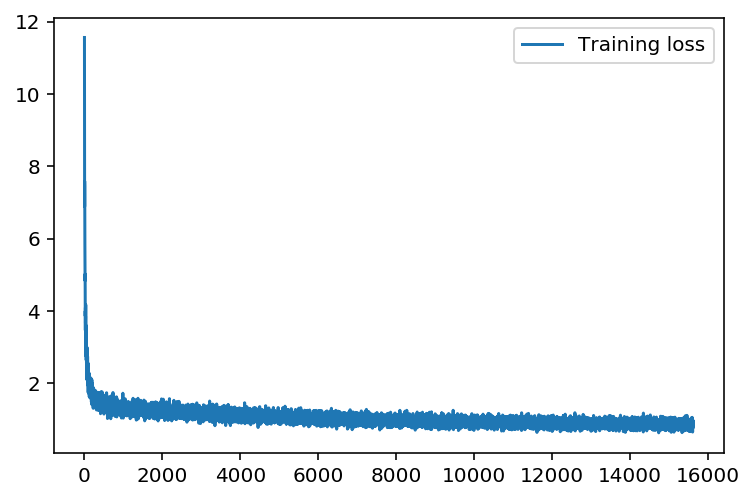

In [40]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
迭代次数再增加一些，下降的趋势会明显一些

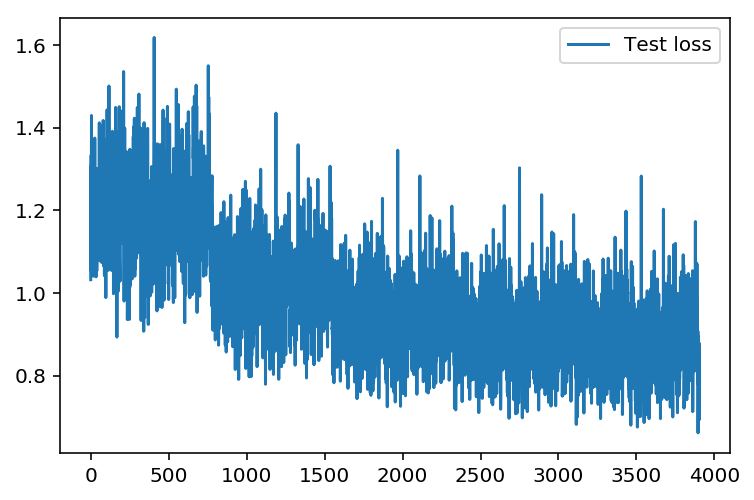

In [41]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors，后面的推荐功能要用到。

In [42]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


## 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [43]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [44]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 3.83278275]], dtype=float32)]

## 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [45]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [46]:
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

## 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [47]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [48]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

## 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [62]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keepdims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
       #     print(val)
            print(movies_orig[val])
        
        return results

In [63]:
recommend_same_type_movie(241, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[241 'Fluke (1995)' "Children's|Drama"]
以下是给您的推荐：
[1577 'Mondo (1996)' 'Drama']
[1504 'Hollow Reed (1996)' 'Drama']
[1245 "Miller's Crossing (1990)" 'Drama']
[2229 'Pleasure Garden, The (1925)' 'Drama']
[515 'Remains of the Day, The (1993)' 'Drama']


{511, 1225, 1472, 1536, 2160}

### 推荐您喜欢的电影
思路是使用用户特征向量与电影特征矩阵计算所有电影的评分，取评分最高的top_k个，同样加了些随机选择部分。

In [60]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):

    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        #推荐您喜欢的电影
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 200])

        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     print(sim.shape)
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
    #     sim_norm = probs_norm_similarity.eval()
    #     print((-sim_norm[0]).argsort()[0:top_k])
    
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
    #      print(val)
            print(movies_orig[val])

        return results


In [59]:
recommend_your_favorite_movie(2341, 10)

INFO:tensorflow:Restoring parameters from ./save
以下是给您的推荐：
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
1162
[1178 'Paths of Glory (1957)' 'Drama|War']
523
[527 "Schindler's List (1993)" 'Drama|War']
2911
[2980 'Men Cry Bullets (1997)' 'Drama']
735
[745 'Close Shave, A (1995)' 'Animation|Comedy|Thriller']


{523, 735, 900, 1162, 2911}

### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [64]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
    #     print(val)
            print(movies_orig[val])
        
        return results

In [65]:
recommend_other_favorite_movie(241, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[241 'Fluke (1995)' "Children's|Drama"]
喜欢看这个电影的人是：[[927 'F' 25 20]
 [2421 'M' 35 7]
 [763 'M' 18 10]
 [1268 'M' 50 2]
 [2696 'M' 25 7]
 [3703 'M' 18 12]
 [3603 'F' 35 7]
 [2496 'M' 50 1]
 [1871 'F' 45 1]
 [2202 'F' 1 10]
 [3595 'M' 25 0]
 [100 'M' 35 17]
 [3031 'M' 18 4]
 [4800 'M' 18 4]
 [1745 'M' 45 0]
 [324 'M' 35 17]
 [4085 'F' 25 6]
 [3780 'M' 1 0]
 [2338 'M' 45 17]
 [4903 'M' 35 12]]
喜欢看这个电影的人还喜欢看：
[3307 'City Lights (1931)' 'Comedy|Drama|Romance']
[2030 'East Palace West Palace (Dong gong xi gong) (1997)' 'Drama']
[629 'Rude (1995)' 'Drama']
[53 'Lamerica (1994)' 'Drama']
[2019 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{52, 624, 1950, 1961, 3238}